In [1]:
%matplotlib inline
# notebook
from IPython.display import Audio, display
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
from shutil import copy
from os.path import join as jp
from tqdm import tqdm
from scipy.io import wavfile as wf
from time import time, sleep
from glob import glob
from classes import get_classes
def float_audio(x, sample_rate=16000, autoplay=False):
    # avoid Audio normalizing the data
    data = np.int16(x * 32768)
    fn = '/tmp/%s.wav' % data[:32]
    wf.write(fn, sample_rate, data)
    display(Audio(filename=fn, rate=sample_rate, autoplay=autoplay))

def plot_audio(data, sample_rate=16000, normed=False):
    if not normed:
        data = np.float32(data) / 32768
    plt.figure()
    plt.plot(np.arange(sample_rate), data)
    plt.axis([0, sample_rate, -1, 1])
    
def center_pad(data, desired_size=16000):
    missing = desired_size - len(data)
    pad_left = missing // 2
    pad_right = missing - pad_left
    padded_data = np.pad(data, (pad_left, pad_right), mode='constant')
    return padded_data

def random_crop(data, desired_size=16000):
    start = np.random.randint(len(data) - desired_size)
    return data[start: start + desired_size]

def normalized_read(fn, desired_size=16000):
    rate, data = wf.read(fn)
    data = np.float32(data) / 32768
    assert rate == 16000
    if len(data) < desired_size:
        data = center_pad(data, desired_size=desired_size)
    elif len(data) > desired_size:
        data = random_crop(data, desired_size=desired_size)
    return data

In [ ]:
sub1 = pd.read_csv('submission_005.csv')
sub2 = pd.read_csv('submission_009.csv')
sub3 = pd.read_csv('submission_010.csv')

In [ ]:
num_total = sub1.shape[0]
fname_equal = (sub1.fname == sub2.fname).sum()
assert fname_equal == num_total
equal = sub1.label == sub2.label
unequal = ~equal
print("Neq: ", equal.sum(), "Nun: ", unequal.sum())

## Display where classifiers disagree
These samples are acutally quite hard!

In [ ]:
TEST_DIR = 'data/test/audio'
for i in range(200):
    if unequal[i]:
        fn = os.path.join(TEST_DIR, sub1.loc[i, 'fname'])
        print(fn, ': ', sub1.loc[i, 'label'], " vs ", sub2.loc[i, 'label'])
        display(Audio(fn))

## Show (predicted) test data distribution
### Note that during training silence prob was 10%

In [ ]:
def show_bar(submission):
    counts = []
    for label_name in submission.label.unique():
        label_count = (submission.label == label_name).sum()
        percent = (label_count / num_total) * 100.0
        counts.append((label_name, percent))
    print(counts)
    plt.bar(range(len(counts)), [c[-1] for c in counts])
    _ = plt.xticks(range(len(counts)), [c[0] for c in counts])
    plt.grid('on')
    plt.xlabel('Label names')
    plt.ylabel('Precentage [%]')

In [ ]:
show_bar(sub1)

# Compress and decompress using mu-law

In [ ]:
def load_wav(fn):
    rate, data = wf.read(fn)
    assert rate == 16000
    data = data / 32768
    missing = 16000 - len(data)
    data = np.pad(data, (missing, 0), mode='constant')
    return data


def compress(x, mu=255):
    assert x.min() >= -1 and x.max() <= 1
    compressed = np.sign(x) * np.log10(1.0 + mu * np.abs(x)) / np.log10(1.0 + mu)
    return compressed

def decompress(x, mu=255):
    assert x.min() >= -1 and x.max() <= 1
    decompressed= np.sign(x) * (1.0 / mu) * (np.power(1.0 + x, np.abs(x)) - 1.0)
    return decompressed

In [ ]:
up_sample = load_wav('data/test/audio/clip_001204892.wav')
float_audio(up_sample)
c = compress(up_sample)
d = decompress(c)
float_audio(d)

In [ ]:
display(Audio(data=np.int16(up_sample  * 32768), rate=16000))

### Use average pooling to reduce signal size

In [ ]:
from keras.models import Model
from keras.layers import AveragePooling1D, Input, Reshape
def avg_model(sample_rate=16000):
    input_layer = Input([sample_rate])
    x = input_layer
    x = Reshape([-1, 1])(x)
    x = AveragePooling1D(2)(x)
    return Model(input_layer, x)

model = avg_model()
out = model.predict([up_sample.reshape((1, -1))]).squeeze()


In [ ]:
plt.figure()
plt.title('Orginal')
plt.plot(up_sample)
plt.figure()
plt.title('Subsamples')
plt.plot(out)

In [ ]:
float_audio(out, sample_rate=len(out))

# Check how many samples are shorter than 1s

In [ ]:
from glob import glob
from tqdm import tqdm
train_fns = sorted(glob('data/train/audio/*/*.wav'))

In [ ]:
def load_wav(fn):
    rate, data = wf.read(fn)
    assert rate == 16000
    return data

short_count = 0
for fn in tqdm(train_fns):
    data = load_wav(fn)
    if len(data) != 16000:
        short_count += 1
print("Short: ", short_count)
print("All: ", len(train_fns))

# Visualize augmented training data

In [ ]:
from keras import backend as K
from input_data import AudioProcessor, prepare_words_list
from classes import get_classes
from model import speech_model, prepare_model_settings

In [ ]:
def data_gen(audio_processor, sess,
             batch_size=128, background_frequency=0.5,
             background_volume_range=0.3, time_shift=(200.0 * 16000.0) / 1000,
             mode='validation'):
    while True:
        X, y = audio_processor.get_data(
            how_many=batch_size, offset=0,
            background_frequency=background_frequency,
            background_volume_range=background_volume_range,
            time_shift=time_shift, mode=mode, sess=sess)
        yield X, y

In [ ]:
sess = K.get_session()
compute_mfcc = False
sample_rate = 16000
batch_size = 64
classes = get_classes(wanted_only=False)
model_settings = prepare_model_settings(
  label_count=len(prepare_words_list(classes)), sample_rate=sample_rate,
  clip_duration_ms=1000, window_size_ms=30.0, window_stride_ms=10.0,
  dct_coefficient_count=40)
ap = AudioProcessor(
  data_dir='data/train/audio',
  silence_percentage=10.0,
  unknown_percentage=10.0,
  wanted_words=classes,
  validation_percentage=10.0,
  testing_percentage=0.0,
  model_settings=model_settings,
  compute_mfcc=compute_mfcc)

In [ ]:
train_gen = data_gen(ap, sess, batch_size=batch_size, mode='training')

In [ ]:
for i in range(10):
    X, y = next(train_gen)
    sample_idx = np.random.randint(batch_size)
    if y[sample_idx, :].argmax() != 0 and y[sample_idx, :].argmax() != 1:
        sample = X[sample_idx, :].squeeze()
        float_audio(sample, autoplay=True)
        sleep(1)
        # plt.figure()
        # plt.axis([0, 16000, -1, 1])
        # plt.plot(sample)

# Create pseudo labels from consistent predictions
### Sub1: 84% PLB, Sub2: 84% PLB, Sub3: 82% PLB

In [ ]:
consistend = ((sub1.label == sub2.label) & (sub1.label == sub3.label))
print("All: ", sub1.shape[0], " consistend: ", consistend.sum())

In [ ]:
for i in tqdm(range(sub1.shape[0])):
    fn = sub1.loc[i, 'fname']
    if fn != sub2.loc[i, 'fname'] or fn != sub3.loc[i, 'fname']:
        print("Fatal error")
        break
    if consistend[i]:
        label = sub1.loc[i, 'label']
        dst_fn = jp('data', 'pseudo', 'audio', label, fn)
        src_fn = jp('data', 'test', 'audio', fn)
        copy(src_fn, dst_fn, follow_symlinks=False)

# Listen to submission

In [ ]:
sub = pd.read_csv('submission_013_all_labels.csv')
disp_count = 0
for i in reversed(range(sub.shape[0])):
    if disp_count >= 10:
        break
    fn = jp('data', 'test', 'audio', sub.loc[i, 'fname'])
    label = sub.loc[i, 'label']
    if label == 'right' and np.random.rand() > 0.8:
        print(label)
        display(Audio(fn, autoplay=True))
        sleep(1)
        disp_count += 1

# Correct broken submission

In [ ]:
sub_broken = pd.read_csv('submission_012.csv')
sub_all = pd.read_csv('submission_012_all_labels.csv')
sub_broken.loc[(sub_all.label == 'unknown').values, 'label'] = 'silence'
sub_broken.to_csv('submission_012_corrected.csv', index=False)

In [ ]:
sub = pd.read_csv('submission_012_corrected.csv')
disp_count = 0
for i in range(sub.shape[0]):
    if disp_count >= 10:
        break
    fn = jp('data', 'test', 'audio', sub.loc[i, 'fname'])
    label = sub.loc[i, 'label']
    if label != 'unknown' and np.random.rand() > 0.9:
        print(label)
        display(Audio(fn, autoplay=True))
        sleep(1)
        disp_count += 1

In [ ]:
sub = pd.read_csv('submission_012_all_labels.csv')
counts = sub.label.value_counts()
percent_counts = counts.apply(lambda x: np.round(100.0 * (x / sub.shape[0])))
# print(counts)
print(percent_counts)

# Check what the generators are producing

In [ ]:
from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import TensorBoard
from model import speech_model, prepare_model_settings
from input_data import AudioProcessor, prepare_words_list
from classes import get_classes


def data_gen(audio_processor, sess,
             batch_size=128,
             background_frequency=0.5, background_volume_range=0.2,
             foreground_frequency=1.0, foreground_volume_range=3.0,
             time_shift=(100.0 * 16000.0) / 1000,
             mode='validation'):
    offset = 0
    if mode != 'training':
        background_frequency = 0.0
        background_volume_range = 0.0
        foreground_frequency = 0.0
        foreground_volume_range = 0.0
        time_shift = 0

    while True:
        X, y = audio_processor.get_data(
            how_many=batch_size, offset=0 if mode == 'training' else offset,
            background_frequency=background_frequency,
            background_volume_range=background_volume_range,
            foreground_frequency=foreground_frequency,
            foreground_volume_range=foreground_volume_range,
            time_shift=time_shift, mode=mode, sess=sess)
        offset += batch_size
        if offset > ap.set_size(mode) - batch_size:
            offset = 0
        yield X, y


sess = K.get_session()
data_dirs = ['data/train/audio']
add_pseudo = False
if add_pseudo:
    data_dirs.append('data/pseudo/audio')
compute_mfcc = False
sample_rate = 16000
batch_size = 64
classes = get_classes(wanted_only=False)
model_settings = prepare_model_settings(
  label_count=len(prepare_words_list(classes)), sample_rate=sample_rate,
  clip_duration_ms=1000, window_size_ms=30.0, window_stride_ms=10.0,
  dct_coefficient_count=40)
ap = AudioProcessor(
  data_dirs=data_dirs,
  silence_percentage=15.0,
  unknown_percentage=7.0,
  wanted_words=classes,
  validation_percentage=10.0,
  testing_percentage=0.0,
  model_settings=model_settings,
  compute_mfcc=compute_mfcc)
train_gen = data_gen(ap, sess, batch_size=batch_size, mode='training')
val_gen = data_gen(ap, sess, batch_size=batch_size, mode='validation')

In [ ]:
ap.summary()

In [ ]:
wanted_words = get_classes(wanted_only=True)
print(wanted_words)
labels2int = {v: k for k, v in ap.word_to_index.items()}

In [ ]:
for i in range(1):
    X, y = next(train_gen)
    y = y.argmax(axis=-1)
    for j in range(len(y)):
        print(labels2int[y[j]])
        float_audio(X[j, :], autoplay=True)
        sleep(1)

### Load model and check where we go wrong in the validation set

In [ ]:
model = speech_model(
  'conv_1d_time',
  model_settings['fingerprint_size'] if compute_mfcc else sample_rate,
  num_classes=model_settings['label_count'])
model.load_weights('checkpoints_014/ep-039-loss-0.173.hdf5')
disp_count = 0
for i in range(ap.set_size('validation') // batch_size):
    if disp_count >= 10:
        break
    X, y_true = next(val_gen)
    y_true = y_true.argmax(axis=-1)
    y_pred = model.predict(X).argmax(axis=-1)
    for j in range(len(y_true)):
        if y_true[j] != y_pred[j] and np.random.rand() > 0.5:
            l_true = labels2int[y_true[j]]
            l_pred = labels2int[y_pred[j]]
            print("Pred: %s, Actual: %s" % (l_pred, l_true))
            float_audio(X[j, :], autoplay=True)
            sleep(1)
            disp_count += 1

# Create "unknown" words
### Just reverse some of the unwanted words. Reversing the wanted words might actually cause some problems since I am using glo

In [ ]:
wanted_words = get_classes(wanted_only=True)
# wow reversed is wow! one reversed sounds like no!
# dog vs go :P
exclude_words = wanted_words + ['_background_noise_', 'wow', 'one', 'dog']

In [ ]:
fns = sorted(glob(jp('data', 'train', 'audio', '*', '*.wav')))
print(len(fns))
fns = [fn for fn in fns if fn.split('/')[-2] not in exclude_words]
print(len(fns))

In [ ]:
np.random.shuffle(fns)
# fn_selection = np.random.choice(fns, size=5000, replace=False)
fn_selection = fns

In [ ]:
# there (often) 5 times the same speaker said the same word
# 
# ./eight/5fadb538_nohash_4.wav
# ./eight/5fadb538_nohash_3.wav
# ./eight/5fadb538_nohash_2.wav
# ./eight/5fadb538_nohash_1.wav
# ./eight/5fadb538_nohash_0.wav

counter = 0
for fn in tqdm(fn_selection):
    sample_rate, data = wf.read(fn)
    bn = os.path.basename(fn)
    dst = jp('data', 'train', 'audio', 'unwrev',
             "%06d.wav" % counter)
    counter += 1
    data = data[::-1]
    wf.write(dst, sample_rate, data)

# Take a look at the noise files

In [ ]:
background_files = sorted(glob(jp('data', 'train', 'audio', '_background_noise_', '*.wav')))
background_volumne = 0.8
for fn in background_files[5:6]:
    print(fn)
    rate, data = wf.read(fn)
    if len(data) > 16000:
        data = data[:16000]
    data = np.float32(data) / 32768
    data *= background_volumne
    print(data.max())
    wf.write('tmp.wav', 16000, np.int16(data * 32767))
    plot_audio(data, normed=True)
    display(Audio('tmp.wav', autoplay=True))
    sleep(1)

In [ ]:
?wf.write

# Take a look at "happy" files

In [ ]:
background_files = sorted(glob(jp('data', 'train', 'audio', 'happy', '*.wav')))
volumne = 10**1
for fn in background_files[5:6]:
    print(fn)
    rate, data = wf.read(fn)
    if len(data) > 16000:
        data = data[:16000]
    data = np.float32(data) / 32768
    data *= volumne
    data = np.clip(data, -1, 1)
    print(data.max())
    wf.write('tmp.wav', 16000, np.int16(data * 32767))
    plot_audio(data, normed=True)
    display(Audio('tmp.wav', autoplay=True))
    sleep(1)

# Majority vote submission

In [ ]:
import pandas as pd
from os.path import join as jp
from shutil import copy
from tqdm import tqdm_notebook as tqdm

sub_fns = ['submission_005.csv', 'submission_009.csv',
           'submission_011.csv', 'submission_014.csv']
subs = [pd.read_csv(sub_fn) for sub_fn in sub_fns]

fname, label = [], []
clear_majority = 0
for i in range(subs[0].shape[0]):
    if i % 5000 == 0:
        print("%d / %d" % (i, subs[0].shape[0]))
    fname.append(subs[0].loc[i, 'fname'])
    label_counts = {}
    for sub in subs:
        ll = sub.loc[i, 'label']
    if ll in label_counts:
        label_counts[ll] += 1
    else:
        label_counts[ll] = 1

    maj_label = max(label_counts, key=label_counts.get)
    if label_counts[maj_label] > 1:
        clear_majority += 1
    else:
        # in trouble save the wav files!
        src = jp('data', 'test', 'audio', fname[-1])
        dst = jp('split_decision', str(label_counts) + fname[-1])
        copy(src, dst)
    # resolve tie by chosing 'unknown' or 'silence' if available
    if 'unknown' in label_counts and 'silence' in label_counts:
        maj_label = 'silence'
    elif 'unknown' in label_counts:
        maj_label = 'unknown'
    elif 'silence' in label_counts:
        maj_label = 'silence'
    label.append(maj_label)

pd.DataFrame({'fname': fname, 'label': label}).to_csv(
    'majority_sub_003.csv', index=False)
print("Done! Got a clear majority for %d of %d samples."
      % (clear_majority, subs[0].shape[0]))


# Generate more background noise
## The idea is to take the reversed words and average some of them up to generate ~30s tracks

In [ ]:
# unwanted words reversed
fns = sorted(glob(jp('data', 'train', 'audio', 'unwrev', '*.wav')))
print(len(fns))

In [ ]:
louder = 16.0  # make it louder!
sample_secs = 30
total_new = 0
num_noise_tracks = 400
noise_track = []
noise_track_counter = 0
sample_track = []
sample_counter = 0
for fn in tqdm(fns):
    sample_rate, data = wf.read(fn)
    data = np.float32(data) / 32768
    assert sample_rate == 16000
    data = center_pad(data)
    shift = np.random.randint(16000)
    data = np.roll(data, shift)
    sample_track.append(data)
    sample_counter += 1
    if sample_counter == sample_secs:
        noise_track.append(np.concatenate(sample_track))
        sample_track = []
        sample_counter = 0
        noise_track_counter += 1
        if noise_track_counter == num_noise_tracks:
            noise_track = np.array(noise_track)
            noise_track = np.mean(noise_track, axis=0) * louder
            noise_track = np.int16(noise_track * 32768)
            out_fn = jp('data', 'train', 'audio', '_background_noise_', 'silence_please_%04d.wav' % total_new)
            wf.write(out_fn, 16000, noise_track)
            print(out_fn)
            display(Audio(out_fn))
            noise_track = []
            noise_track_counter = 0
            total_new += 1
            if total_new == 2:
                break

# How does foreground with mixed background sound?

In [2]:
background_noise_fns = sorted(glob('data/train/audio/_background_noise_/*.wav'))
idx = -3
print(background_noise_fns[idx])
display(Audio(background_noise_fns[idx], autoplay=True))

data/train/audio/_background_noise_/silence_please_0000.wav


data/train/audio/_background_noise_/doing_the_dishes.wav


/usr/local/lib/python3.5/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


data/train/audio/_background_noise_/doing_the_dishes.wav


data/train/audio/_background_noise_/dude_miaowing.wav


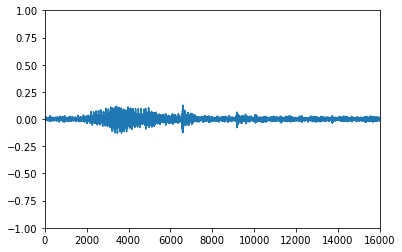

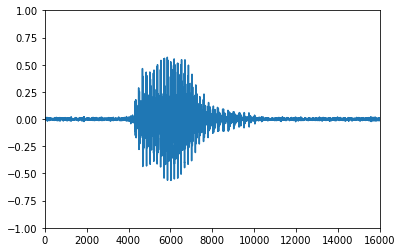

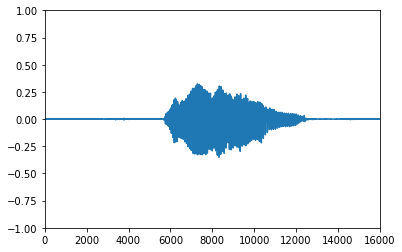

In [3]:
foreground_fns = sorted(glob('data/train/audio/go/*.wav'))
for i in range(3):
    foreground_fn = np.random.choice(foreground_fns)
    foreground = normalized_read(foreground_fn)
    background_fn = np.random.choice(background_noise_fns)
    # background_fn = background_noise_fns[-3]
    print(background_fn)
    background = normalized_read(background_fn)
    mixed = np.random.uniform(0.8, 1.2) * foreground + 0.3 * background  # np.random.uniform(0, 2)
    mixed = np.clip(mixed, -1, 1)
    float_audio(mixed, autoplay=True)
    plot_audio(mixed, normed=True)
    sleep(1)

# How do the models perform on the validation set?

In [2]:
from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import TensorBoard
from model import speech_model, prepare_model_settings
from input_data import AudioProcessor, prepare_words_list
from keras.models import load_model
from classes import get_classes


def data_gen(audio_processor, sess,
             batch_size=128,
             background_frequency=0.5, background_volume_range=0.2,
             foreground_frequency=1.0, foreground_volume_range=3.0,
             time_shift=(100.0 * 16000.0) / 1000,
             mode='validation'):
    offset = 0
    if mode != 'training':
        background_frequency = 0.0
        background_volume_range = 0.0
        foreground_frequency = 0.0
        foreground_volume_range = 0.0
        time_shift = 0

    while True:
        X, y = audio_processor.get_data(
            how_many=batch_size, offset=0 if mode == 'training' else offset,
            background_frequency=background_frequency,
            background_volume_range=background_volume_range,
            foreground_frequency=foreground_frequency,
            foreground_volume_range=foreground_volume_range,
            time_shift=time_shift, mode=mode, sess=sess)
        offset += batch_size
        if offset > ap.set_size(mode) - batch_size:
            offset = 0
        yield X, y


sess = K.get_session()
data_dirs = ['data/train/audio']
add_pseudo = False
if add_pseudo:
    data_dirs.append('data/pseudo/audio')
compute_mfcc = False
sample_rate = 16000
batch_size = 64
classes = get_classes(wanted_only=False)
model_settings = prepare_model_settings(
  label_count=len(prepare_words_list(classes)), sample_rate=sample_rate,
  clip_duration_ms=1000, window_size_ms=30.0, window_stride_ms=10.0,
  dct_coefficient_count=40)
ap = AudioProcessor(
  data_dirs=data_dirs,
  silence_percentage=15.0,
  unknown_percentage=7.0,
  wanted_words=classes,
  validation_percentage=10.0,
  testing_percentage=0.0,
  model_settings=model_settings,
  compute_mfcc=compute_mfcc)
train_gen = data_gen(ap, sess, batch_size=batch_size, mode='training')
val_gen = data_gen(ap, sess, batch_size=batch_size, mode='validation')

Using TensorFlow backend.


In [3]:
model_fns = [
    'checkpoints_019/ep-022-vl-0.2916.hdf5',
    'checkpoints_018/ep-049-vl-0.2185.hdf5',
    'checkpoints_017/ep-036-vl-0.1969.hdf5'
]

models = []
for model_fn in model_fns:
    model = load_model(model_fn)
    models.append((model_fn, model))

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


KeyboardInterrupt: 

In [ ]:
# evaluate on validation set
for model in models:
    out = model.evaluate_generator(
        val_gen, steps=ap.set_size('validation') // batch_size)
    print(model_fn, out)

# Predict samples with models

In [4]:
len(ap.words_list), len(models)

(32, 2)

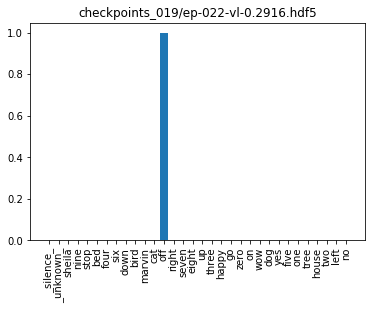

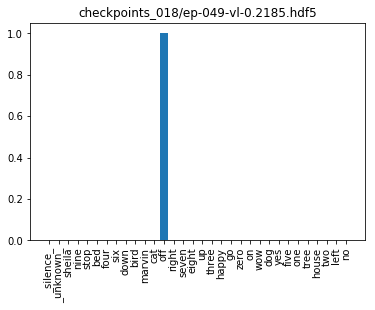

In [5]:
X, y = next(val_gen)
sample_idx = 10
float_audio(X[sample_idx, :], autoplay=True)
out_probs = []
for model_fn, model in models:
    y_preds = model.predict(X)
    out_probs.append((model_fn, y_preds[sample_idx]))

for fn, pred in out_probs:
    plt.figure()
    plt.title(fn)
    plt.bar(range(len(pred)), pred)
    plt.xticks(range(len(pred)), ap.words_list, rotation='vertical')

# Wrong ones

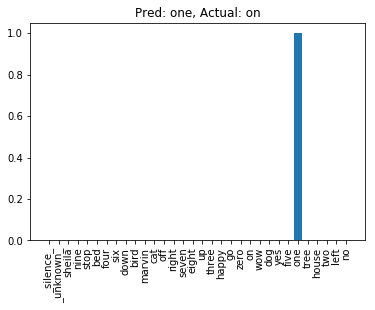

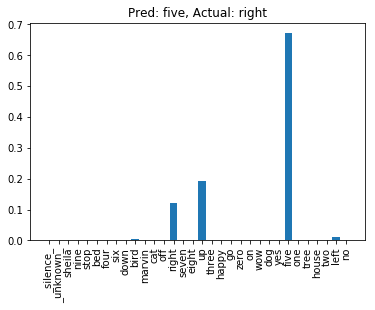

In [7]:
max_plots = 2
plot_c = 0
model = models[-1][-1]
while plot_c < max_plots:
    X, y = next(val_gen)
    y_preds = model.predict(X)
    for i, y_pred in enumerate(y_preds):
        if plot_c >= max_plots:
            break
        if y_pred.argmax() != y[i].argmax():
            float_audio(X[i, :], autoplay=True)
            sleep(1)
            plt.figure()
            plt.title("Pred: %s, Actual: %s"
                      % (ap.words_list[y_pred.argmax()], ap.words_list[y[i].argmax()]))
            plt.bar(range(len(y_pred)), y_pred)
            plt.xticks(range(len(y_pred)), ap.words_list, rotation='vertical')
            plot_c += 1

# What happens if we just feed plain silence e.g. all 0?
### Looks good!

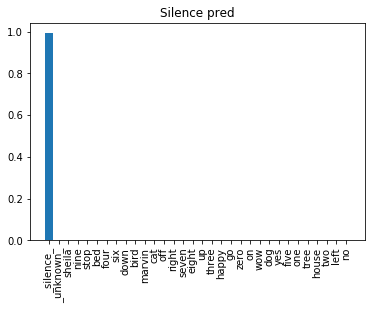

In [87]:
X = np.zeros((2, 16000), dtype=np.float32)
pred = model.predict(X)
float_audio(X[0, :], autoplay=True)
sleep(1)
plt.figure()
plt.title("Silence pred")
plt.bar(range(len(pred[0])), pred[0])
_ = plt.xticks(range(len(pred[0])), ap.words_list, rotation='vertical')

# How about the noise files?

In [12]:
model = load_model(model_fns[-1])

/usr/local/lib/python3.5/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


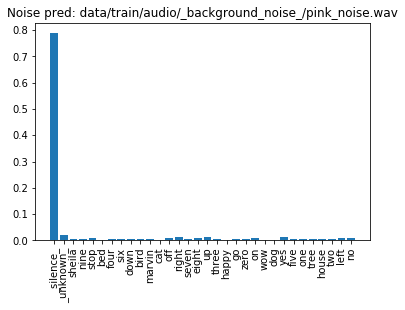

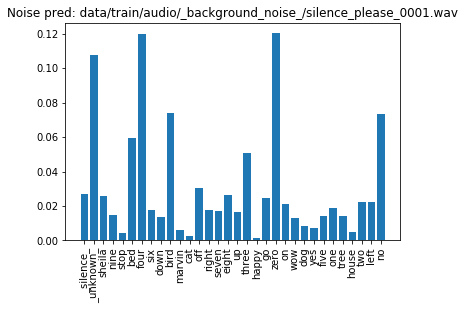

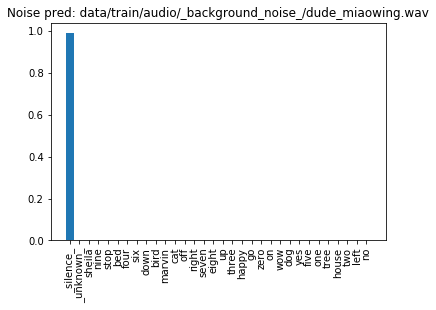

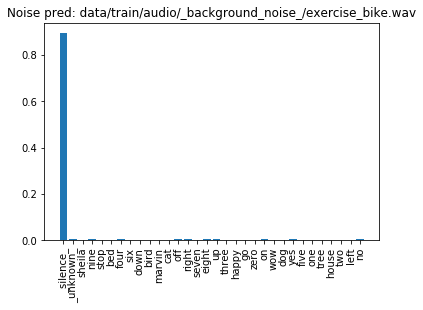

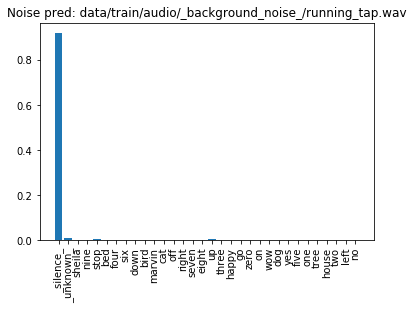

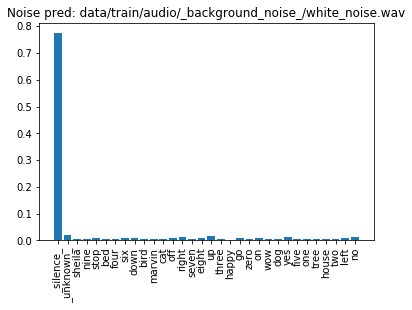

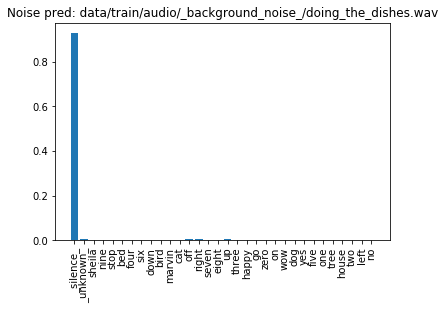

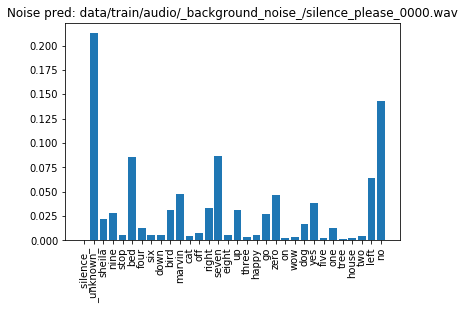

In [15]:
noise_fns = glob(jp('data/train/audio/_background_noise_/*.wav'))
X = []
for noise_fn in noise_fns:
    X.append(normalized_read(noise_fn))
X = np.float32(X)
# change volumne
X *= 0.2
y_pred = model.predict(X)
for i in range(X.shape[0]):
    # float_audio(X[0, :], autoplay=True)
    # sleep(1)
    plt.figure()
    plt.title("Noise pred: %s" % noise_fns[i])
    plt.bar(range(len(y_pred[i])), y_pred[i])
    _ = plt.xticks(range(len(y_pred[i])), ap.words_list, rotation='vertical')